In [2]:
# import librarires
import torch
import numpy as np
from IPython import get_ipython
get_ipython().magic('matplotlib inline')
get_ipython().magic("config InlineBackend.figure_format = 'retina'")

In [9]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

In [10]:
# Define the Network Architecture
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # number of hidden nodes in each layer (512)
        hidden_1 = 512
        hidden_2 = 512
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(28 * 28, hidden_1)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(hidden_2, 10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add output layer
        x = self.fc3(x)
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [11]:
# Specify Loss Function and Optimizer
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [12]:
# Training model
# number of epochs to train the model
n_epochs = 50

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.944633 	Validation Loss: 0.375526
Validation loss decreased (inf --> 0.375526).  Saving model ...
Epoch: 2 	Training Loss: 0.356039 	Validation Loss: 0.287386
Validation loss decreased (0.375526 --> 0.287386).  Saving model ...
Epoch: 3 	Training Loss: 0.281377 	Validation Loss: 0.236050
Validation loss decreased (0.287386 --> 0.236050).  Saving model ...
Epoch: 4 	Training Loss: 0.232356 	Validation Loss: 0.199726
Validation loss decreased (0.236050 --> 0.199726).  Saving model ...
Epoch: 5 	Training Loss: 0.198025 	Validation Loss: 0.174228
Validation loss decreased (0.199726 --> 0.174228).  Saving model ...
Epoch: 6 	Training Loss: 0.171373 	Validation Loss: 0.156555
Validation loss decreased (0.174228 --> 0.156555).  Saving model ...
Epoch: 7 	Training Loss: 0.150966 	Validation Loss: 0.142705
Validation loss decreased (0.156555 --> 0.142705).  Saving model ...
Epoch: 8 	Training Loss: 0.135479 	Validation Loss: 0.130139
Validation loss decreased (0.14270

In [15]:
# Load the Model with the Lowest Validation Loss
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [18]:
# Test the Trained Network
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.060784

Test Accuracy of     0: 98% (969/980)
Test Accuracy of     1: 99% (1127/1135)
Test Accuracy of     2: 98% (1013/1032)
Test Accuracy of     3: 98% (996/1010)
Test Accuracy of     4: 97% (957/982)
Test Accuracy of     5: 97% (874/892)
Test Accuracy of     6: 98% (945/958)
Test Accuracy of     7: 97% (1005/1028)
Test Accuracy of     8: 96% (943/974)
Test Accuracy of     9: 97% (985/1009)

Test Accuracy (Overall): 98% (9814/10000)


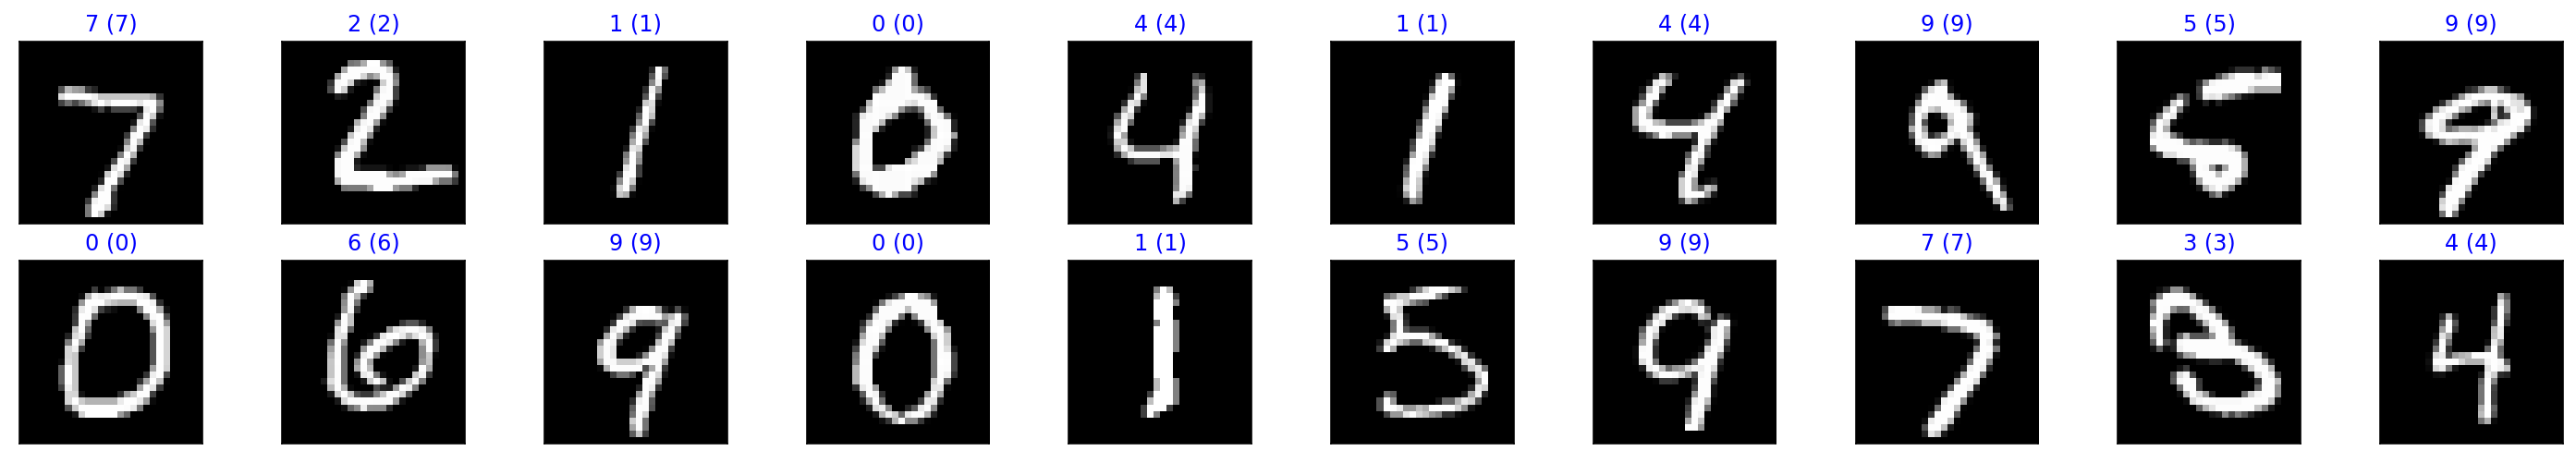

In [19]:
# Visualize Sample Test Results
# obtain one batch of test images
import matplotlib.pyplot as plt
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("blue" if preds[idx]==labels[idx] else "red"))